# Genetic algorithm model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl 
from scipy.optimize import differential_evolution
from scipy.optimize import LinearConstraint, minimize
from pandas_datareader import data
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

### Securities Input Data

The input data of this model are the names and the values of the securities. The next step involves the calculation of the arithmetic return for the selected securities.

In [2]:
companyName = ['ACN', 'NOC', 'IBM', 'MSI', 'MSCI', 'ORA']
startDate = '2016-01-01'
endDate = '2018-12-31'

historicalValues = data.DataReader(companyName, 'yahoo', startDate, endDate)
stockValues = historicalValues['Open']
numOfDates = stockValues.shape[0]
numSecurities = stockValues.shape[1]
stockValues = stockValues.fillna(method='ffill')

numPeriods = numOfDates - 1
stockValuesArray = pd.DataFrame(stockValues).to_numpy()
secReturns = np.empty(shape = (numPeriods, numSecurities))
for i in range(numSecurities):
    for j in range(numPeriods):
        secReturns[j][i] = (stockValuesArray[j+1][i]-stockValuesArray[j][i])/stockValuesArray[j][i]
returnDates = stockValues.index[1:]
stockReturns = pd.DataFrame(secReturns, index=returnDates, columns=stockValues.columns) 
print("============  Stock Returns  ============ \n")
display(stockReturns)

============  Stock Returns  ============ 



Symbols,ACN,NOC,IBM,MSI,MSCI,ORA
Date,,,,,,
2016-01-05,-0.006334,0.010055,0.008554,-0.017290,-0.006892,-0.013472
2016-01-06,-0.011376,0.012297,-0.017403,-0.013985,-0.004957,-0.010242
2016-01-07,-0.010515,-0.011885,-0.005060,-0.014336,-0.014518,0.007186
2016-01-08,-0.002707,0.004737,-0.003889,-0.004642,0.004911,0.013699
2016-01-11,-0.010052,-0.006939,-0.010287,0.005130,-0.011785,0.006475
...,...,...,...,...,...,...
2018-12-24,-0.031485,-0.023837,-0.023111,-0.039567,-0.035735,-0.006997
2018-12-26,-0.013033,-0.026096,-0.017288,-0.012801,-0.004623,0.000979
2018-12-27,0.017136,0.019953,0.018426,0.010593,0.030964,0.000000


### Market Index Input Data

The same process is followed for the market index. In this case we select the NASDAQ Composite index (^IXIC) because the seleted securities belong to NASDAQ stock exchange. Therefore, we calculate the returns of the market index for the selected time horizon.

In [3]:
historicalValues = data.DataReader('^FCHI', 'yahoo', startDate, endDate)
indexValues = historicalValues['Open']
numOfDates = stockValues.shape[0]
indexValues = indexValues.fillna(method='ffill')
display(indexValues)

numPeriods = numOfDates - 1
indexValuesArray = pd.DataFrame(indexValues).to_numpy()
marketReturns = np.empty(shape = (numPeriods))
for j in range(numPeriods):
    marketReturns[j] = (indexValuesArray[j+1]-indexValuesArray[j])/indexValuesArray[j]
indexReturns = pd.DataFrame(marketReturns, index=returnDates) 
print("============  Stock Returns  ============ \n")
display(indexReturns)


Date
2016-01-04    4582.049805
2016-01-05    4573.540039
2016-01-06    4528.120117
2016-01-07    4346.100098
2016-01-08    4404.180176
                 ...     
2018-12-21    4672.770020
2018-12-24    4650.419922
2018-12-27    4689.200195
2018-12-28    4641.049805
2018-12-31    4708.740234
Name: Open, Length: 767, dtype: float64

============  Stock Returns  ============ 



,0
Date,
2016-01-05,-0.001857
2016-01-06,-0.009931
2016-01-07,-0.040198
2016-01-08,0.013364
2016-01-11,-0.016114
...,...
2018-12-24,-0.014793
2018-12-26,-0.014646
2018-12-27,-0.013062


### Multiobjective Function

In this point, we define the multiobjective function losses, which is about to be optimised. This function calculates the number of times that the portfolio return is smaller than the selected marfket index return for all dates during the selected time period. This function needs to be minimised, as the target is to maximise the number of times that the portfolio offers a better return.

In [4]:
def losses(x):
    losingTimes = 0
    portfReturn = [0 for i in range(numPeriods)]
    for i in range(numPeriods):    
        for j in range(numSecurities):
            portfReturn[i] += x[j] * secReturns[i][j]
        if portfReturn[i] < marketReturns[i]:
            losingTimes += 1            
    return losingTimes

Finally, the function differential_evolution solves this evolutionary problem. The list of variables bounds sets the limits for each security's percentage in the portfolio. The function LinearConstraint imposes the capital completeness constraint. The parameters of the model are the following (according to the scipy documentation):

* maxiter: The maximum number of generations over which the entire population is evolved.
* popsizeint: A multiplier for setting the total population size. The population has popsize * len(x) individuals.
* mutation: The mutation constant. In the literature this is also known as differential weight, being denoted by F.
* recombinationfloat: The recombination constant, should be in the range [0, 1]. Also known as the crossover probability, being denoted by CR. Increasing this value allows a larger number of mutants to progress into the next generation, but at the risk of population stability.

/home/elissaios/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:812: UserWarning: differential evolution didn't find a solution satisfying the constraints, attempting to polish from the least infeasible solution
  " infeasible solution", UserWarning)
/home/elissaios/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


ACN :  0.2115
NOC :  0.1565
IBM :  0.1265
MSI :  0.2572
MSCI :  0.125
ORA :  0.1233
Percentage that portfolio beats the index: 0.5179282868525896


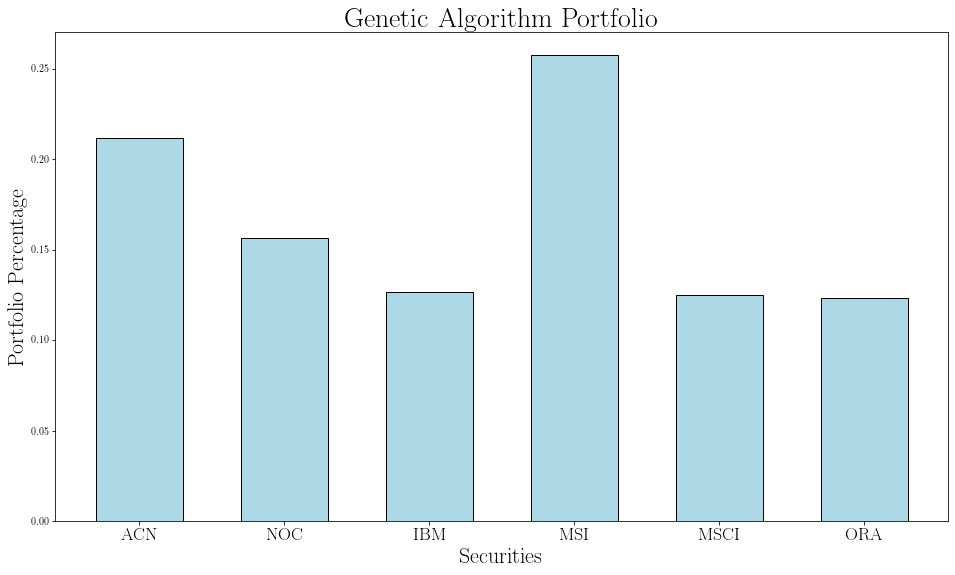

In [5]:
bounds = [(0,1) for i in range(numSecurities)]
constraints = LinearConstraint(np.ones(numSecurities), 1, 1)
result = differential_evolution(losses, bounds, maxiter=10, polish=True, popsize=30, mutation=1.95,
                                updating='deferred', recombination=0.9, constraints=constraints)

for i in range(numSecurities):
    print(companyName[i],": ", np.round(result.x[i],4))
print("Percentage that portfolio beats the index:", (numPeriods-result.fun)/numPeriods)

plt.figure(figsize=(16,9))
plt.bar(companyName, result.x, color = 'lightblue', edgecolor = 'black', width=0.6)
plt.xlabel(r"Securities", fontsize=22)
plt.ylabel(r"Portfolio Percentage", fontsize=22)
plt.title(r"Genetic Algorithm Portfolio", fontsize=28)
plt.xticks(fontsize=18, rotation=0)
plt.savefig("barplot13.png", dpi=300)